Form has no parts with arity 2.


/tmp/ipykernel_432/3805040170.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")
/tmp/ipykernel_432/3805040170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")


Text(0, 0.5, '$\\rho (mm.mm^{-2})$')

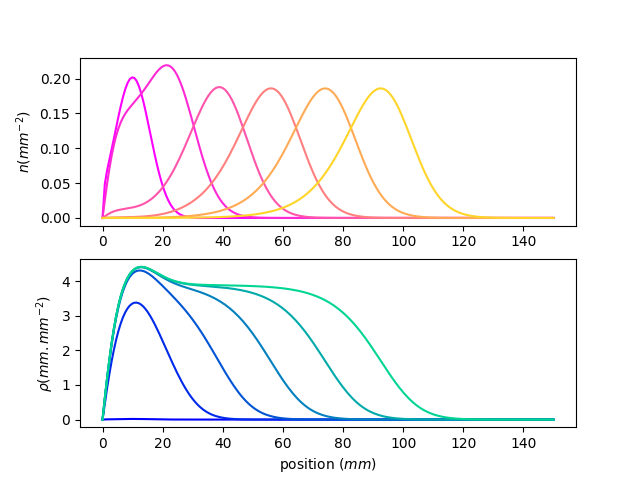

In [4]:
%matplotlib widget
from dolfin import *
import numpy as nump
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
plt.close("all")
set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 150.0
nx = 200
nT = 900
mesh = IntervalMesh(nx, 0, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Define the parameters
T = 400
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
u0 = Expression(('0.2*exp(-0.015*pow(abs(x[0]-10),2))',0), degree=1)


# Define other elements

u_n = interpolate(u0, V)
u = Function (V)
n, rho = split(u)
n_n, rho_n= split(u_n)
v_1, v_2 = TestFunctions(V)
k = Constant((1,))

s_scal = Constant(0.2)
beta = Constant(0.02)
alpha = Constant(alphval)
D = Constant(0.55)

n_mid = 0.5*(n_n + n)
v_s = Constant((0,))

# Define the variational problem


F = n*v_1*dx - n_n*v_1*dx 
F += dt*dot(grad(n_mid),v_s)*v_1*dx


F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx
F += beta*v_1*rho*(n)*dt*dx
F -= alpha*(n)*v_1*dt*dx
# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 0.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
a, L = lhs(F), rhs(F)
V2 = FunctionSpace(mesh, 'P', 1)
X = nump.linspace(0,Length,nx)
poss = []

fix,axs = plt.subplots(2,1)
i=0
for t in nump.linspace(0,T,nT):

    solve(F==0, u,bcs)
    u_n.assign(u)
    _n, _rho= u.split()
    n_field = interpolate(_n, V2)
    if i%150==0:
        rho_field = interpolate(_rho, V2)
        axs[0].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        axs[1].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
    poss.append(nump.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('')
axs[0].set_ylabel('$n (mm^{-2})$')

# axs[2].set_xlabel('position (x)')
# axs[2].set_ylabel('$n_p$')

axs[1].set_xlabel('position ($mm$)')
axs[1].set_ylabel(r'$\rho (mm.mm^{-2})$')
    



Text(0, 0.5, 'x ($mm$)')

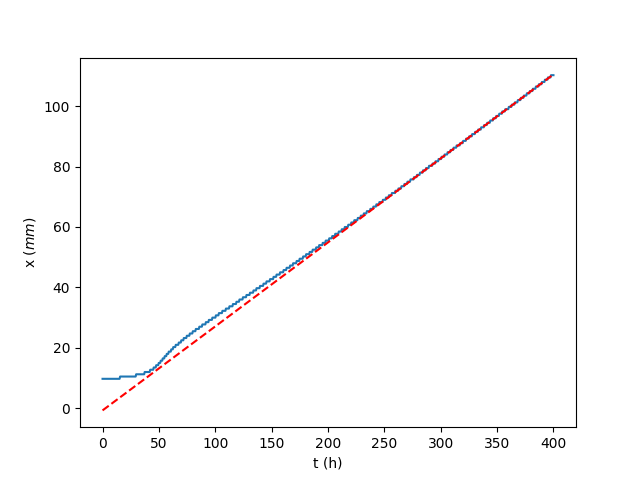

In [7]:
x = nump.linspace(0,T,nT)
y = nump.array(poss)*Length/nx
fit_coeffs = nump.polyfit(x[3*nT//4:], y[3*nT//4:], 1)
fit_line = nump.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')